In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from shapely import wkt


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [3]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d36 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_36.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)


fifty_seven = pd.read_csv('../data/fifty_seventh_assem.csv')
fifty_seven = fifty_seven[['aded','percphara','percmos']]
full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_thirty_six = full_results[full_results['district'] == 36]


In [55]:
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')

## The District 

District 36 is primarily Budford-Stuvyset with a portion of Crown Heights. The district is historically a center of Black political power and is currently one of the centers of rapid demographic change. 53% of the district is non-Hispanic Black, putting in the top quintile of council districts. While its is relatively low in white population in general, in the next to lowest quintile, is is in the second quintile of white transplant population, with 10 percent of the district being NH whites born out of state. 

In [4]:
full_results_thirty_six.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Chi A. Osse         8445.0
Henry L. Butler     5361.0
Tahirah A. Moore    5264.0
Robert Waterman     3222.0
Reginald Swiney      615.0
Write-in              84.0
overvote              67.0
219539.0              61.0
219533.0              33.0
218576.0              16.0
218675.0              10.0
221439.0               6.0
Name: vote, dtype: float64

In [5]:
eds_36 = full_results_thirty_six['ed_name'].unique().tolist()

In [56]:
top_three = full_results_thirty_six[full_results_thirty_six['candidate'].isin(['Chi A. Osse','Henry L. Butler','Tahirah A. Moore'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [7]:
winners['candidate'].value_counts()

candidate
Chi A. Osse         79
Henry L. Butler     20
Tahirah A. Moore    17
Name: count, dtype: int64

In [8]:
def assign_color(row):
    if row['candidate'] == 'Chi A. Osse':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] == 'Henry L. Butler':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])

In [57]:
winners['color'] = winners.apply(assign_color, axis=1)

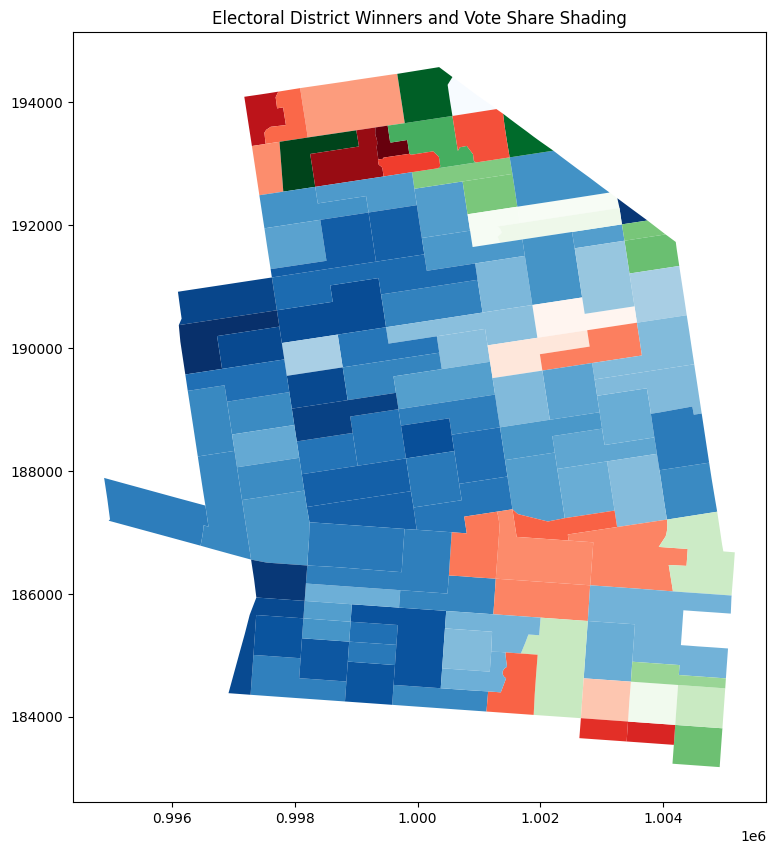

In [12]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [10]:
hb = full_results_thirty_six[full_results_thirty_six['candidate'] == 'Henry L. Butler']

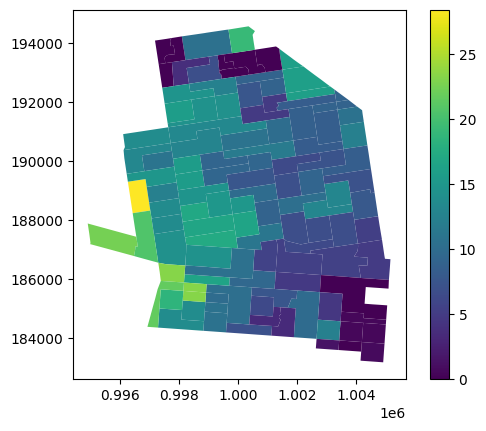

In [ ]:
hb.plot(column='white_transplant_ratio',legend=True)
plt.show()

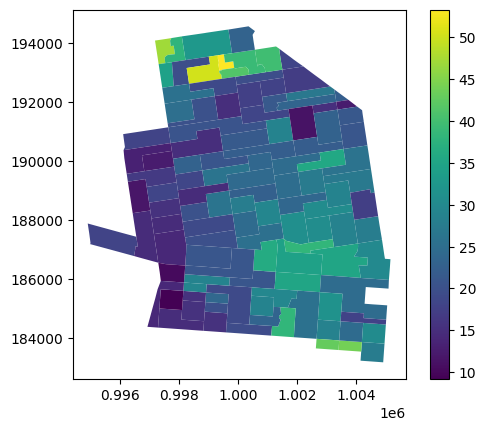

In [14]:
hb = gpd.GeoDataFrame(hb,geometry=hb['geometry'].apply(wkt.loads))
hb.plot(column='vote_share',legend=True)
plt.show()

In [58]:
winners = winners[['candidate','ed_name','white_transplant_ratio','adams213p', 'bus_ratio', 'dpp20bs', 'hh21op', 'vote_share']].merge(ed_level, left_on = 'ed_name', right_on = 'ElectDist')

In [59]:
winners = winners.merge(occ_df, left_on = 'ed_name', right_on = 'ElectDist',how='left')

In [63]:
p_cols = [col for col in occ_df.columns if col[-1] == 'p']
wp_cols = [col for col in occ_df.columns if col.startswith("w2") and col.endswith("p")]
wp_cols.remove('w2cop')

In [69]:
tdc = ['w2hsp','w2govp','w2mgtp','w2admp','w2npp']

In [70]:
winners.groupby('candidate')[tdc].agg("mean")

,w2hsp,w2govp,w2mgtp,w2admp,w2npp
candidate,,,,,
Chi A. Osse,7.026119,15.270848,12.841944,11.498912,12.171968
Henry L. Butler,18.442077,20.964653,6.866116,5.903333,12.703727
Tahirah A. Moore,16.747506,14.189387,7.839034,7.517251,11.370634


In [65]:
mean_values = winners.groupby('candidate')[wp_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      11.415958
w2govp      6.775266
w2mgtp      5.975827
w2admp      5.595579
w2psp       3.843500
w2foodp     3.799795
w2banp      3.445499
w2ffp       2.931861
w2bgp       2.914686
w2oadp      2.757806
dtype: float64


In [12]:
winners.groupby('candidate').agg({'vote_share':'mean',
                                  'white_transplant_ratio':'mean',
                                  'mhhi21':'mean',
                                  'hh21op':'mean',
                                  'adams213p':'mean',
                                  'dpp20bs':'mean',
                                    'cvap21bapp':'mean',
                                    'bus_ratio':'mean',
                                    'Retail Trade':'mean',
                                    'Information':'mean',
                                    'Professional, Scientific, and Technical Services':'mean',
                                    'Educational Services':'mean',
                                    'Health Care and Social Assistance':'mean',
                                    'Construction':'mean'
}).round(2)

,vote_share,white_transplant_ratio,mhhi21,hh21op,adams213p,dpp20bs,cvap21bapp,bus_ratio,Retail Trade,Information,"Professional, Scientific, and Technical Services",Educational Services,Health Care and Social Assistance,Construction
candidate,,,,,,,,,,,,,,
Chi A. Osse,40.50,12.30,80372.90,23.33,48.52,203.33,40.46,6.59,11.00,4.83,8.30,5.66,19.91,3.12
Henry L. Butler,37.58,4.19,66642.07,15.17,68.86,95.47,31.85,13.34,11.94,3.86,6.91,5.55,21.68,3.37
Tahirah A. Moore,36.10,7.19,50181.59,15.53,61.89,110.79,33.27,12.67,11.76,4.07,7.35,5.00,20.55,3.53


In [6]:
d36.groupby('district_36_choice_1')['district_36_choice_2'].value_counts(dropna=False).reset_index(name='count').sort_values('count', ascending=False).head(10)

,district_36_choice_1,district_36_choice_2,count
0,Chi A. Osse,Tahirah A. Moore,3645
1,Chi A. Osse,NaN,2534
8,Henry L. Butler,NaN,1754
31,Tahirah A. Moore,NaN,1621
32,Tahirah A. Moore,Chi A. Osse,1577
9,Henry L. Butler,Tahirah A. Moore,1299
23,Robert Waterman,NaN,1159
2,Chi A. Osse,Robert Waterman,1152
10,Henry L. Butler,Robert Waterman,1054
33,Tahirah A. Moore,Henry L. Butler,997


salazar primary

In [40]:
colnames = ['a', 'b', 'c', 'd', 'e', 'f',
       'g', 'h', 'i', 'j',
       'k', 
        'AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

good_cols = ['AD', 'ED', 'County', 'EDAD Status', 'Event', 'Party/Independent Body',
       'Office/Position Title', 'District Key', 'VoteFor', 'Unit Name',
       'Tally']

In [45]:
sp = pd.read_csv('../data/salazar_raw_primary.csv',header=None, names=colnames)
sp = sp[good_cols]

In [46]:
sp['precinct'] = 'AD: ' + sp['AD'].astype(str) + ' ' + 'ED: ' + sp['ED'].astype(str).str.zfill(3)
sp['ed_name'] = sp['AD'].astype(str) + sp['ED'].astype(str).str.zfill(3)

In [48]:
candidates = ['Julia Salazar','Martin Malave Dilan']

In [49]:
sp_cand = sp[sp['Unit Name'].isin(candidates)]
sp_cand = sp_cand[['precinct','ed_name','Unit Name','Tally']]

In [50]:
sp_cand.columns = ['precinct','ed_name','candidate','votes']

In [51]:
sp_cand['ed_total'] = sp_cand.groupby('ed_name')['votes'].transform('sum')
sp_cand['vote_share'] = round(sp_cand['votes'] / sp_cand['ed_total'] * 100,2)

In [52]:
sp_cand['vote_share'] = pd.to_numeric(sp_cand['vote_share'], errors='coerce')
sp_cand = sp_cand.dropna(subset=['vote_share'])

In [53]:
max_vote_share_candidates = sp_cand.loc[sp_cand.groupby('ed_name')['vote_share'].idxmax()]

In [55]:
max_vote_share_candidates['candidate'].value_counts()

candidate
Julia Salazar          147
Martin Malave Dilan     89
Name: count, dtype: int64

In [56]:
max_vote_share_candidates.to_csv('../data/max_vote_share_candidates_js.csv',index=False)

In [57]:
mvsc_js = max_vote_share_candidates.copy()

In [72]:
mvsc_jb = pd.read_csv('../data/max_vote_share_candidates.csv')
mvsc_js = pd.read_csv('../data/max_vote_share_candidates_js.csv')

In [73]:
mvs = pd.concat([mvsc_js,mvsc_jb])

In [74]:
mvs_36 = mvs[mvs['ed_name'].isin(eds_36)]

In [75]:
mvs_36['candidate'].value_counts()

candidate
Jabari Brisport        55
Tremaine S. Wright     33
Julia Salazar          13
Martin Malave Dilan    10
Name: count, dtype: int64

In [76]:
mvs_36_map = mvs_36.merge(ed_gdf, left_on = 'ed_name',right_on='ElectDist')
mvs_36_map = gpd.GeoDataFrame(mvs_36_map,geometry=mvs_36_map['geometry'])

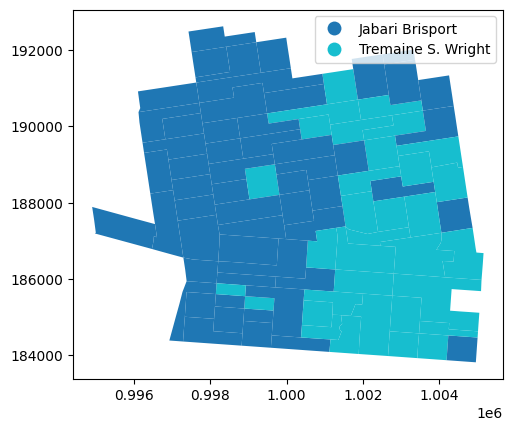

In [70]:
mvs_36_map.plot(column='candidate',legend=True)
plt.show()

In [77]:
mvs_36.columns = ['precinct','ed_name','sen_candidate','votes','ed_total','vote_share']

In [133]:
winners_br = winners.merge(mvs_36, on = 'ed_name', how = 'left')

In [80]:
winners_br['sen_candidate'].value_counts()

sen_candidate
Jabari Brisport        55
Tremaine S. Wright     33
Julia Salazar          13
Martin Malave Dilan    10
Name: count, dtype: int64

In [134]:
winners_br.dropna(subset=['sen_candidate'],inplace=True)

In [135]:
conditions = [
    (winners_br["candidate"] == "Chi A. Osse") & 
    (winners_br["sen_candidate"].isin(['Julia Salazar',"Jabari Brisport"])),
    
    (winners_br["candidate"] == "Chi A. Osse") & 
    (winners_br["sen_candidate"].isin(['Martin Malave Dilan',"Tremaine S. Wright"])),
    
    (winners_br["candidate"].isin(['Henry L. Butler','Tahirah A. Moore'])) & 
    (winners_br["sen_candidate"].isin(['Julia Salazar',"Jabari Brisport"])),

    (winners_br["candidate"].isin(['Henry L. Butler','Tahirah A. Moore'])) & 
    (winners_br["sen_candidate"].isin(['Martin Malave Dilan',"Tremaine S. Wright"])),
]

values = ['dsa_stonghold','prog_not_dsa','dsa_not_prog','non_prog'] 

winners_br["cc_sen_cats"] = np.select(conditions, values, default=0)

In [87]:
winners_br['cc_sen_cats'].value_counts()

cc_sen_cats
dsa_stonghold    59
non_prog         24
prog_not_dsa     19
dsa_not_prog      9
Name: count, dtype: int64

In [99]:
top_diff_cols = ['w2hsp','w2govp','w2mgtp','w2admp','w2npp','w2psp']

In [100]:
winners_br.groupby('cc_sen_cats')[top_diff_cols].agg("mean")

,w2hsp,w2govp,w2mgtp,w2admp,w2npp,w2psp
cc_sen_cats,,,,,,
dsa_not_prog,14.784762,12.416222,7.103771,8.958833,10.947898,66.144075
dsa_stonghold,7.163919,14.426166,13.002832,12.127849,12.275481,62.527433
non_prog,19.350597,19.737162,7.158380,5.629815,12.383139,60.920899
prog_not_dsa,6.398340,18.118427,12.754268,9.655495,11.831248,59.772062


In [98]:
mean_values = winners_br.groupby('candidate')[wp_cols].agg("mean")
diffs = mean_values.max() - mean_values.min()  
top_diff_cols = diffs.nlargest(10)
print(top_diff_cols)

w2hsp      13.085257
w2govp      6.431897
w2mgtp      5.948496
w2admp      5.733716
w2psp       4.567109
w2banp      3.513990
w2foodp     3.428646
w2bgp       3.320802
w2oadp      2.672164
w2ffp       2.657992
dtype: float64


In [112]:
key_demo_cols = ['white_transplant_ratio','nhw21p','nhb21p', 'bus_ratio', 'mhhi21', 'cvap21bapp']
key_demo_cols.extend(top_diff_cols)

In [136]:
df_cluster = winners_br[key_demo_cols]

In [137]:
scaler = StandardScaler()
df_cluster_scaled = scaler.fit_transform(df_cluster)

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

Text(0.5, 1.0, 'Elbow Method')

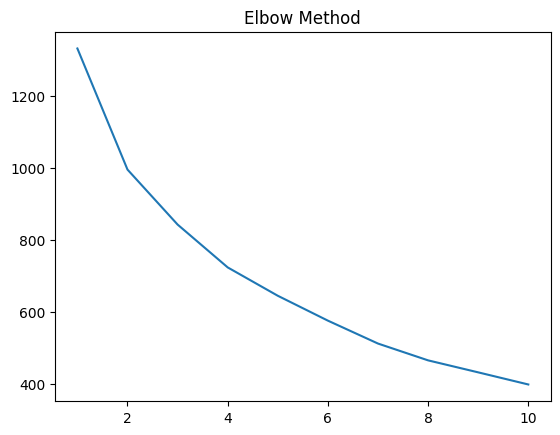

In [115]:
# elbow method to determine number of clusters
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_cluster_scaled)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia)
plt.title('Elbow Method')

In [138]:
kmeans = KMeans(n_clusters=5, random_state=14)
kmeans.fit(df_cluster_scaled)
winners_br['occ_cluster'] = kmeans.labels_

c:\Users\samtg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [130]:
winners_br.groupby('occ_cluster')[key_demo_cols].agg("mean")

,white_transplant_ratio,nhw21p,nhb21p,bus_ratio,mhhi21,cvap21bapp,w2hsp,w2govp,w2mgtp,w2admp,w2npp,w2psp
occ_cluster,,,,,,,,,,,,
0,0.000001,5.743136,33.465335,23.362909,29415.409727,18.640635,42.702607,18.783548,2.254108,0.847797,19.358635,59.709608
1,16.220384,30.069700,33.533743,3.875735,55905.365998,49.830120,4.503478,13.462521,16.823785,11.655522,15.689413,59.449652
2,8.491230,22.597548,21.081107,9.088345,90856.110916,37.690287,12.272124,15.820518,10.033501,7.939228,9.492755,65.405335
3,5.601641,15.646747,41.777565,13.620584,57312.535986,35.091040,7.130335,23.532109,9.323103,8.188468,11.685941,55.740621
4,14.576627,21.214961,19.659743,3.947672,100906.010329,36.582089,6.523172,11.444904,12.041690,15.473326,10.932754,65.625051


In [121]:
winners_br['occ_cluster'] = winners_br['occ_cluster'].astype('category')

In [123]:
winners_br.groupby('cc_sen_cats').agg({'nhw21p':'mean',
                                       'nhb21p':'mean',
                                  'white_transplant_ratio':'mean',
                                  'mhhi21':'median',
                                  'hh21op':'mean',
                                  'adams213p':'mean',
                                  'dpp20bs':'mean',
                                    'cvap21bapp':'mean',
                                    'bus_ratio':'mean',
                                    'Retail Trade':'mean',
                                    'Information':'mean',
                                    'Professional, Scientific, and Technical Services':'mean',
                                    'Educational Services':'mean',
                                    'Health Care and Social Assistance':'mean',
                                    'Construction':'mean',
                                    'Management of Companies and Enterprises':'mean',
                                    'Finance and Insurance':'mean'
}).round(2)

,nhw21p,nhb21p,white_transplant_ratio,mhhi21,hh21op,adams213p,dpp20bs,cvap21bapp,bus_ratio,Retail Trade,Information,"Professional, Scientific, and Technical Services",Educational Services,Health Care and Social Assistance,Construction,Management of Companies and Enterprises,Finance and Insurance
cc_sen_cats,,,,,,,,,,,,,,,,,
dsa_not_prog,19.78,24.39,8.47,42704.31,16.42,60.00,127.19,34.25,11.66,11.69,4.25,7.62,5.25,20.05,3.28,1.71,5.44
dsa_stonghold,22.52,27.47,13.46,69721.73,21.77,45.74,213.27,39.90,5.66,11.11,4.85,8.34,5.41,19.72,3.09,1.80,5.73
non_prog,15.33,28.09,4.52,62767.75,17.03,67.78,105.26,32.01,14.29,11.91,3.86,6.94,5.43,21.40,3.44,1.63,4.98
prog_not_dsa,25.85,31.83,8.89,84042.48,28.42,56.86,173.73,42.13,9.38,10.66,4.79,8.18,6.44,20.55,3.19,1.79,5.98


In [119]:
cor_cols = ['vote_share_x','vote_share_y', 'mhhi21','cvap21bapp', 'dpp20bs','nhb21p', 'nhw21p','white_transplant_ratio',]

In [120]:
cor_matrix = winners_br[cor_cols].corr()
cor_matrix

,vote_share_x,vote_share_y,mhhi21,cvap21bapp,dpp20bs,nhb21p,nhw21p,white_transplant_ratio
vote_share_x,1.000000,0.479872,-0.047944,0.217616,0.536167,0.097924,0.049708,0.462823
vote_share_y,0.479872,1.000000,-0.134642,0.095673,0.471443,-0.106776,0.006232,0.426187
mhhi21,-0.047944,-0.134642,1.000000,-0.162835,-0.250226,-0.678223,-0.062276,-0.091693
cvap21bapp,0.217616,0.095673,-0.162835,1.000000,0.499500,0.205515,0.688311,0.526628
dpp20bs,0.536167,0.471443,-0.250226,0.499500,1.000000,0.012202,0.289943,0.746586
nhb21p,0.097924,-0.106776,-0.678223,0.205515,0.012202,1.000000,0.015101,-0.098088
nhw21p,0.049708,0.006232,-0.062276,0.688311,0.289943,0.015101,1.000000,0.485411
white_transplant_ratio,0.462823,0.426187,-0.091693,0.526628,0.746586,-0.098088,0.485411,1.000000


In [139]:
winners_br = winners_br.merge(ed_gdf, left_on = 'ed_name',right_on='ElectDist')
winners_br_map = gpd.GeoDataFrame(winners_br,geometry=winners_br['geometry'])

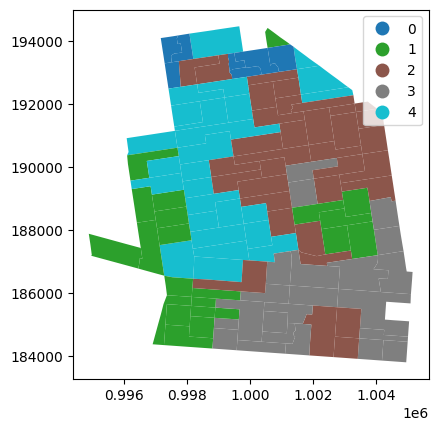

In [140]:
winners_br_map["occ_cluster"] = winners_br_map["occ_cluster"].astype('category')
winners_br_map.plot(column='occ_cluster',legend=True,cmap = 'tab10')
plt.show()

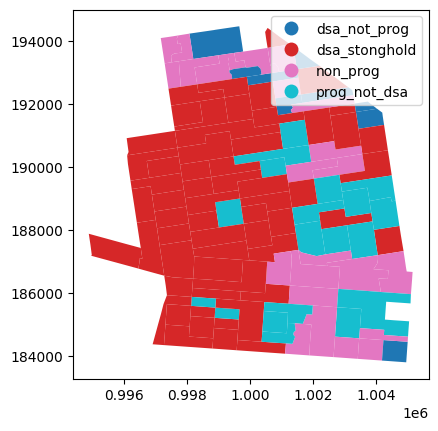

In [141]:
winners_br_map["cc_sen_cats"] = winners_br_map["cc_sen_cats"].astype('category')
winners_br_map.plot(column="cc_sen_cats",legend=True,cmap = 'tab10')
plt.show()